### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [3]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med])) 
        
    return n.reshape(total,3) , total

def usuário(n, x, y):
    z_med = 1.5 #m
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),z_med]))
    return UE.reshape(n,3)

In [4]:
from scipy.io import loadmat

In [5]:
H = loadmat("./models/channel.mat")
H

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 7.1.0, 2022-06-05 23:58:48 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'impulse_response': array([[[[-2.08174676e-07+8.59606098e-06j,
            8.52391486e-06+1.10579993e-06j,
            1.98853568e-06-8.35882938e-06j, ...,
           -2.32702621e-06-8.18492888e-06j,
           -8.37002465e-06+1.51566109e-06j,
            6.92484750e-07+8.47475649e-06j],
          [-1.33670404e-08+1.36785405e-09j,
           -1.27883096e-08+4.10334808e-09j,
           -1.16508242e-08+6.66826664e-09j, ...,
           -1.32476903e-08-3.80394593e-10j,
           -1.29742134e-08+2.67137897e-09j,
           -1.20029140e-08+5.58719524e-09j],
          [ 4.26517339e-09-4.87243620e-09j,
            2.13411187e-09-6.11050852e-09j,
           -3.08353458e-10-6.46204204e-09j, ...,
            4.71545639e-09+4.30791579e-09j,
            6.02090845e-09+2.12147014e-09j,
            6.36764227e-09-4.04167622e-10j],
          ...,
          [ 4.82691220e

In [26]:
np.size(H['Hfreq'],axis=0)

64

#### Calculating parameters

In [8]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
# BS,n_bs = bases(gap_bs, 100, 100,3)
n_bs = 1
BS = np.array([[0,0,3]])
#Dropa usuario aleatorio na area dos lados especificados
# UE = usuário(n_ue, 100, 100)
n_ue = 1
UE = np.array([[10,10,1]])
#Carrier frequency
f0 = 5.8e9 #Hz
#User band
Δf = 120e3 #Hz
#Numero de portadoras (OFDM)
n_f = 240
#Spectral density of noise
N0=-127#dBm

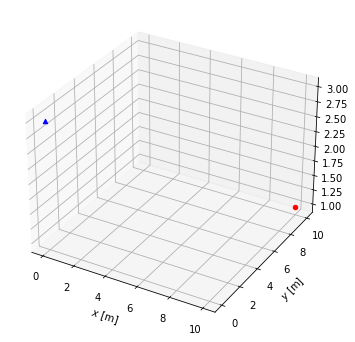

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
# plt.zlabel("$z$ [m]")

for i in range(n_bs):
    ax.scatter(BS[i][0], BS[i][1], BS[i][2], marker='^',color='blue')
for n in range(n_ue):
    ax.scatter(UE[n][0], UE[n][1], UE[n][2], marker='o',color='red')

Signal matrix $s(t)$:

In [132]:
P = inv_dbm(30)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
S = np.zeros([n_ue,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P)
#Noise
var_ruido = inv_dbm(-127)*Δf/2 
η = np.random.normal(0,np.sqrt(var_ruido))+1j*np.random.normal(0,np.sqrt(var_ruido))

# np.random.normal(0,np.sqrt(var_ruido))
# Received signal Y(f)
Y = H @ S + η

S_inv = np.linalg.inv(S)
R =  Y@S_inv

for j in range(n_ue):
    for i in range(n_bs):
        R[j][i] = R[j][i]*np.exp(-1j*φ[j][i])

# Vector of delays
h = np.fft.ifft(R)

#Sample rate
fs = n_f*Δf
Ts = 1/fs
t = np.linspace(0,n_f-1,n_f)*Ts

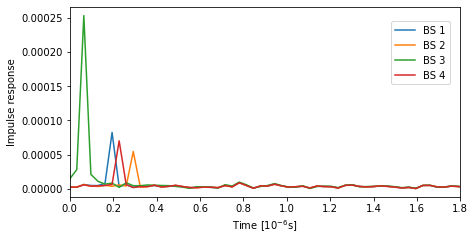

In [133]:
plt.figure(figsize=(7,3.5))

for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(t*1e6,np.abs(h[0][i]),label=label)

plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,1.8)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
# plt.grid()

In [134]:
c = 3e8 #m/s
τ_est = np.zeros([n_ue,n_bs])
D_est = np.zeros_like(τ_est)

for j in range(n_ue):
    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h[j])
    τ_est[j]=np.apply_along_axis(lambda k:t[k], 0, i_τ)
    D_est[j] = τ_est[j]*c

#True values:
D = np.zeros_like(D_est)
for j in range(n_ue):
    for i in range(n_bs):
        D[j][i]=np.linalg.norm(BS[i]-UE[j])
    τ = D/c

#Erro de distancia (metros)
erro_D = np.abs(D-D_est)